# Biodiversity Intactness of Phoenix, AZ
**Author**: Sofia Sarak

**Github Repository:** https://github.com/sofiasarak/biodiversity_phoenix

## Overview

The following notebook contains analyses exploring the changes in biodiversity in the Phoenix area using Biodiversity Intactness Index (BII) data from 2017 and 2020. Outputs include the percentage of the Phoenix area that has a BII of at least 0.75 (both years) and a map depicting the change in high BII (>= 0.75) over the two years.

### Analysis Highlights
1. Use `rioxarray` functionality to clip raster data to match a vector polygon.
2. Access raster values using `numpy` and resolution of grid cells using `rioxarray` to calculate percent area.
3. Perform raster masking with `xarray`'s `.where()` method to find and plot an area -- specifically a difference in area -- that meets a certain condition. 

### Data

**Biodiversity Intactness Index:** 

The Biodiversity Intactness Index estimates how much of a region’s natural, undisturbed biodiversity is still left. It is represented as a percentage, from 0 to 100, with 100 being perfectly natural and undisturbed area. BII data is accessed through the [Microsoft Planetary Computer STAC catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). Rasters from the years 2017 and 2020 area accessed, then cropped to the Phoenix area.

**Phoenix Subdivision:** 

Phoenix geometry (vector) data is sourced from the [TIGER/Line shapefiles](https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision), from the U.S. Census Bureau. The files used correspond to Arizona counties and subdivisions from 2024.

**Base Map:**

For one of our outputs, we plot the Phoenix subdivision onto a cropped map of Arizona. For this we accessed a geotile from the `contextily` package, which is a small Python package that retrieves tile maps from the internet.

### References

Arribas-Bel, D. (2025). contextily (version 1.6.2) [Software]. https://github.com/geopandas/contextily

Microsoft. (n.d.). io-biodiversity [Dataset]. Microsoft Planetary Computer. Accessed December 6, 20205. https://planetarycomputer.microsoft.com/dataset/io-biodiversity

U.S. Census Bureau, U.S. Department of Commerce. (2025). TIGER/Line Shapefile, Current, State, Arizona, County Subdivision [Dataset]. data.gov. Accessed December 6, 2025. https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision



## Setup

In [1]:
## Import necessary libraries
# Data wrangling
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rioxr
from shapely import box
import xarray as xr
# Plotting
import contextily as ctx # Basemap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# To access, sign, and display STAC catalog
from pystac_client import Client  
import planetary_computer  
from IPython.display import Image 


## Accessing BII Data 

BII data will come from the Microsoft Plantary Computer Catalog, which contains STAC data. STAC, or SpatioTemporal Asset Catalog, is an emerging open standard for geospatial data, used especially with satellite imagery. 

In [2]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

To properly access our data of interest, there are a few variables we need to specify beforehand.

First, our catalog search will require a `datetime` input, since we have specific years we want to search for. We can specify two string objects that contain the range of dates we want: January 1st through December 31st for both 2017 and 2020.

In [3]:
# Specify date ranges and set as objects
range_2017 = "2017-01-01/2017-12-31"
range_2020 = "2020-01-01/2020-12-31"

The catalog search will also require a bounding box (bbox) to search within, as we have a specific area that we wish to gather data for. We can create a bbox using `[x_min, y_min, x_max, y_max]` coordinates for the broader geographic area surrounding Phoenix.

In [4]:
# Creating bbox of Phoenix region
phoenix_bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

The last piece of information we need to know is the name of the STAC collection we wish to retrieve. In our case, this is `io-biodiversity`, which contains BII data.

Now that we have the date range, bbox, and name of collection, we can do a catalog search for our data. We will do this twice to find data for both 2017 and 2020.

### Perform catalog search

In [5]:
## 2017
# Search MPC datalog
search_2017 = catalog.search(collections = ['io-biodiversity'],
                            bbox = phoenix_bbox,
                            datetime = range_2017)

# Retrieve search items
items_2017 = search_2017.item_collection()
print(f"Returned {len(items_2017)} length")

## 2020
# Search MPC datalog
search_2020 = catalog.search(collections = ['io-biodiversity'],
                            bbox = phoenix_bbox,
                            datetime = range_2020)

# Retrieve search items
items_2020 = search_2020.item_collection()
print(f"Returned {len(items_2020)} length")

Returned 1 length
Returned 1 length


From our print statements, we know that each item we retrieved from the catalog only has object in it. We can gather more information about our catalog search by accessing the item asset keys and their descriptions. 

In [6]:
# Save the first (and only) item from our search
item_2017 = items_2017[0]

# Print assets for 2017
for key in item_2017.assets.keys():
    print(key, '--', item_2017.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [7]:
# Save the first (and only) item from our search
item_2020 = items_2020[0]

# Print assets for 2020
for key in item_2020.assets.keys():
    print(key, '--', item_2020.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


We now know that both of our data files contain biodiversity intactness data, TileJSON information, and a rendered preview. Let's take a look at our 2017 rendered preview!

In [8]:
# Preview rendered image of BII within our Pheonix bbox
Image(url = item_2017.assets['rendered_preview'].href, width=500)

We know that the actual BII data is stored within the "data" asset of our search items, and we have a visual of what the 2017 data looks like. For use later on, we will save this "data" asset as `bii_2017` and `bii_2020`.

In [9]:
# Use rioxarray to access item data asset
bii_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)
bii_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)

We can take a look at the raster, xarray objects to gather some preliminary information.

In [10]:
bii_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [11]:
bii_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

From these output, because we see that there is a third dimension called "band" with no significant values, we can use the method `squeeze` to remove that band, and make our data two dimensional (as that is how the information is actually stored, anyway).

In [12]:
# Remove length 1 dimension (band), 2017
bii_2017 = bii_2017.squeeze().drop_vars('band')
print("Size of dimensions: ", dict(bii_2017.sizes))

# Remove length 1 dimension (band), 2020
bii_2020 = bii_2020.squeeze().drop_vars('band')
print("Size of dimensions: ", dict(bii_2020.sizes))

Size of dimensions:  {'y': 7992, 'x': 7992}
Size of dimensions:  {'y': 7992, 'x': 7992}


### BII Data Summary

From our preliminary exploration, we have obtained 2017 and 2020 data for BII within the broader Phoenix area bounding box. Outputs of our xarray object tell us that our coordinates x and y are both of size 7992, and store `float64` data. We know generally what BII looks like when plotted, as well.

## Phoenix Subdivision

### Load in Data

In [13]:
# Use os to build filepath to Arizona subdivision data
fp = os.path.join('data','tl_2020_04_cousub','tl_2020_04_cousub.shp')

# Read in data using geopandas
subs = gpd.read_file(fp)

### Data Exploration

In [14]:
# Return first three rows of data frame
subs.head(3)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,015,91964,02582914,0401591964,Lake Havasu City,Lake Havasu City CCD,22,Z5,G4040,None,None,None,S,7493863105,50863803,+34.7686221,-113.8749805,"POLYGON ((-114.48778 34.71722, -114.48622 34.7..."
1,04,007,91277,02582913,0400791277,Fort Apache,Fort Apache CCD,22,Z5,G4040,None,None,None,S,2134058292,4388167,+33.8847663,-110.3394452,"POLYGON ((-110.78327 34.16750, -110.78276 34.1..."
2,04,003,90306,01934923,0400390306,Bisbee,Bisbee CCD,22,Z5,G4040,None,None,None,S,1610943633,3494169,+31.4580397,-110.0783372,"POLYGON ((-110.46089 31.47376, -110.46089 31.4..."


In [15]:
# Data types stored within each column
subs.dtypes

STATEFP       object
COUNTYFP      object
COUSUBFP      object
COUSUBNS      object
GEOID         object
NAME          object
NAMELSAD      object
LSAD          object
CLASSFP       object
MTFCC         object
CNECTAFP      object
NECTAFP       object
NCTADVFP      object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [16]:
# Shape of data frame returned as (# of rows, # of columns)
subs.shape

(80, 19)

In [17]:
# Is one of the subdivisions correspond to Phoenix?
if "Phoenix" in subs['NAME'].values:
    print('Phoenix stored as subdivision')

# Check lowercase version as well, just in case
if "phoenix" in subs['NAME'].values:
    print('Phoenix stored as subdivision')

Phoenix stored as subdivision


### Subdivision Data Summary

From our exploration, we know that this dataset stores 19 variables, but the ones of interest to us are perhaps `NAME`, where the name of each Arizone county/subdivision is stored, as well as the geometry data that we will have to use to clip and plot. We also confirmed that those two variables are stored as we would expect them to be: a string and a geometry, respectively.

In our final code chunk, we were able to confirm that there is an observation stored under Phoenix, making the filtering process in our next steps quite simple!

### Extract Phoenix Geometry and Plot

In [18]:
# Filter subs df for just the Phoenix subdivision
phoenix_sub = subs[subs['NAME'] == "Phoenix"]

# Confirm we get back one row of data
phoenix_sub

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
46,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,None,None,None,S,2805901266,10048820,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


<Axes: >

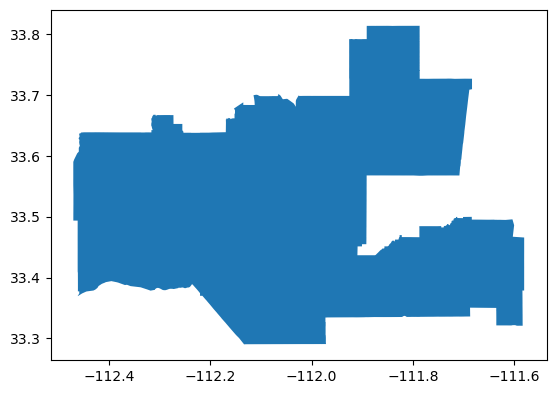

In [19]:
# Preliminary plot to see Phoenix shape/confirm geometry is stored properly
phoenix_sub.plot()

### Phoenix in Context

We will lot the boundary using a basemap from the `contextily` package to help us better visualize the area we are working with.

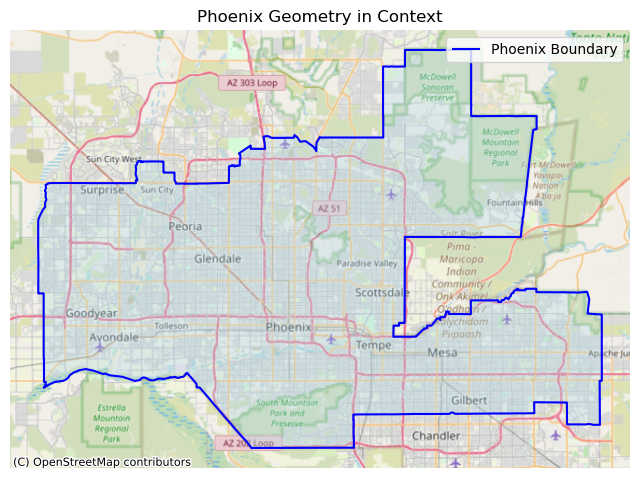

In [20]:
# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot phoenix_sub (fill)
phoenix_sub.plot(ax = ax,
                color = "lightblue",
                alpha = 0.3)

# Plot phoenix_sub (boundary)
phoenix_sub.boundary.plot(ax=ax,
                          color = "blue",
                          label = "Phoenix Boundary")

# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik,
               crs = phoenix_sub.crs)

# Add legend (using labels from .plot()) and title
plt.legend()
plt.title('Phoenix Geometry in Context')

# Turn of axes as they don't give us any beneficial information
ax.axis('off')

plt.show()

## Percentage of BII in Phoenix that is at least 0.75

For the next part of the analysis, we will find the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 and in 2020.

The first step will be to clip the BII data to exactly match the shape of the Phoenix subdivision. As always, we need to ensure that the CRSs of our data match before we can proceed with geospatial operations using both.

In [21]:
# Match CRSs of Phoenix and bii
phoenix_match = phoenix_sub.to_crs(bii_2017.rio.crs)

#  Verify update for both 2017 and 2020
assert phoenix_match.crs == bii_2017.rio.crs
assert phoenix_match.crs == bii_2020.rio.crs

When clipping, we first want to clip the bii rasters to the bounding box of Phoenix. Otherwise clipping to the exact shape would take a lot of computational time, when starting from a large set of data as is stored in `bii_2017` and `bii_2020`.

In [22]:
## Clip BII 
# 2017
bii_2017_clip = bii_2017.rio.clip_box(*phoenix_match.total_bounds).rio.clip(phoenix_match.geometry)

#2020
bii_2020_clip = bii_2020.rio.clip_box(*phoenix_match.total_bounds).rio.clip(phoenix_match.geometry)

We now want to check which value the raster is using when pixels have no data. Before I change cells with no data to 0 (a value that will help ensure accuracy in our analysis moving forward), I also want to confirm that there are no cells that have an actual BII of 0.

In [24]:
# Confirm that there are no values within either of our rasters that = 0
# 2017
if (bii_2017_clip == 0).any():
    print("There are cells that represent a BII of 0, change `no data` to something else!")
else:
    print("No cells contain a BII of 0, you may proceed with updating.")

#2020
if (bii_2020_clip == 0).any():
    print("There are cells that represent a BII of 0, change `no data` to something else!")
else:
    print("No cells contain a BII of 0, you may proceed with updating.")

No cells contain a BII of 0, you may proceed with updating.
No cells contain a BII of 0, you may proceed with updating.


Great! Now I can proceed with replacing raster cells with no data to contain a value of 0.

In [25]:
# 2017
print('Original no-data value for 2017: ', bii_2017_clip.rio.nodata)

# Update raster's no-data value
bii_2017_clip = bii_2017_clip.rio.write_nodata(0)
print('Updated no-data value for 2017: ', bii_2017_clip.rio.nodata)

# 2020
print('Original no-data value for 2020: ', bii_2020_clip.rio.nodata)

# Update raster's no-data value
bii_2020_clip = bii_2020_clip.rio.write_nodata(0)
print('Updated no-data value for 2020: ', bii_2020_clip.rio.nodata)

Original no-data value for 2017:  None
Updated no-data value for 2017:  0.0
Original no-data value for 2020:  None
Updated no-data value for 2020:  0.0


To check that our clipping operation worked, we can plot our clipped 2017 and 2020 rasters.

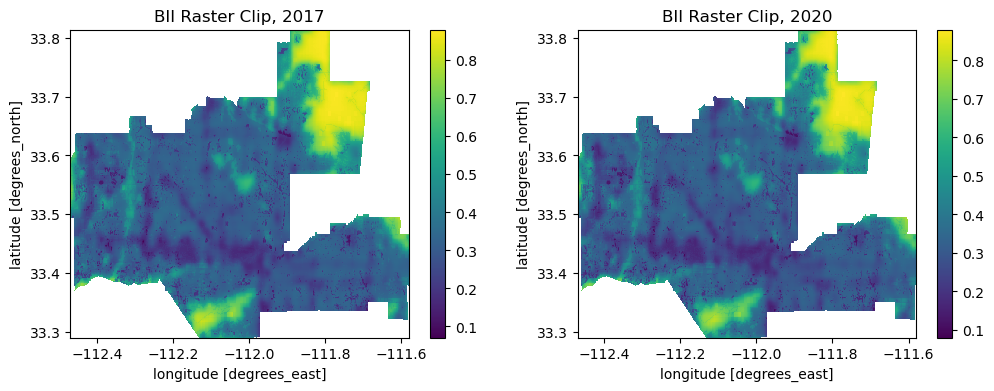

In [26]:
# Initialize plot
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

## 2017
bii_2017_clip.plot(ax = ax[0])

# Post-clip
bii_2020_clip.plot(ax = ax[1])

# Add titles for each plot
ax[0].set_title( 'BII Raster Clip, 2017')
ax[1].set_title( 'BII Raster Clip, 2020')

# Turn of axes as they don't give us any beneficial information
#ax.axis('off')

plt.show()

Everything looks good! We could also check the shape by doing the following:

In [27]:
# Print shape of rasters to confirm clipped is smaller than original
print('Original shape, 2017: ', bii_2017.shape)
print('Clipped shape, 2017: ', bii_2017_clip.shape)

Original shape, 2017:  (7992, 7992)
Clipped shape, 2017:  (583, 990)


## Finding BII of at least 0.75

Now that we have our BII data clipped to our area of interest for both years, we can calculate the percentage of the Phoenix area has a BII of at least 0.75. This will later be used to viualize the areas in which high levels biodiversity were lost from 2017 to 2020.

We will follow these general steps:

1. Find number of cells that contain each BII and filter for only BII >= 0.75. Find sum.
2. Find metric area of each raster cell.
3. Multiply cell area by sum of cells >= 0.75 to get area of BII >= 0.75
4. Find total area of Phoenix subdivision by taking total number of cells * cell metric area.
5. Calculate percentage: area of >=0.75 / total Phoenix area.
6. Repeat for 2020.

In [28]:
# Find the number of cells corresponding to each unique value in bii_2017
values, counts = np.unique(bii_2017_clip, return_counts = True)

# Create dataframe from this information 
d = {'bii' : values,
     'cell_count' : counts
     }

cells_2017 = pd.DataFrame(d)

In [29]:
# Filter dataframe to only include values of bii that are equal or greater than 0.75
# And sum the number of cells
high_bii_2017 = cells_2017[cells_2017['bii'] >= 0.75].sum().iloc[1]

In [30]:
# To get the area of a single cell, we first need to reproject to a CRS that uses metric units (current one is in lat/long)
bii_2017_clip_meters = bii_2017_clip.rio.reproject('epsg:8859')

# Use resolution method to extract x and y of cell size 
res = bii_2017_clip_meters.rio.resolution()

# Save the cell size area by multiplying the two sides
single_cell_area = res[0] * abs(res[1])

In [31]:
# Multiply single cell area by total number of cells in Phoenix subdivision with bii >= 0.75
high_bii_2017_area = single_cell_area * high_bii_2017/1000 # dividing my 1000 to convert into km

Find area of entire Phoenix subdivision. We can do this by using the same operation as before, but selecting for all cells that contain a BII *greater than* 0. Since we set no data cells to 0, we know that anything greater would correspond to the Phoenix area within the raster.

In [32]:
# Find total number of cells in Phoenix sub raster
total_area_cells = cells_2017[cells_2017['bii'] > 0].sum().iloc[1]

# Multiply by cell area
total_area = single_cell_area * total_area_cells/1000

Use total area and BII >= 0.75 area to find percentage of the Phoenix subdivision that had a BII of at least 0.75 in 2017.

In [33]:
# Find percentage
perc_high_bii_2017 = high_bii_2017_area / total_area * 100

print(f"The percentage of the Phoenix area that had a BII of at least 0.75 in 2017 is {perc_high_bii_2017:.2f}%")

The percentage of the Phoenix area that had a BII of at least 0.75 in 2017 is 7.13%


Now we can repeat the process for 2020!

In [34]:
# Find the number of cells corresponding to each unique value in bii_2017
values, counts = np.unique(bii_2020_clip, return_counts = True)

# Create dataframe from this information 
d = {'bii' : values,
     'cell_count' : counts
     }

cells_2020 = pd.DataFrame(d)

# Filter dataframe to only include values of bii that are equal or greater than 0.75
# And sum the number of cells
high_bii_2020 = cells_2020[cells_2020['bii'] >= 0.75].sum().iloc[1]

# Get the area of a single cell (reproject first)
bii_2020_clip_meters = bii_2020_clip.rio.reproject('epsg:8859')

# Use resolution method to extract x and y of cell size 
res = bii_2020_clip_meters.rio.resolution()

# Save the cell size area by multiplying the two sides
single_cell_area = res[0] * abs(res[1])

# Multiply single cell area by total number of cells in Phoenix subdivision with bii >= 0.75
high_bii_2020_area = single_cell_area * high_bii_2020/1000

# Find total number of cells in Phoenix sub raster
total_area_cells = cells_2017[cells_2017['bii'] > 0].sum().iloc[1]

# Multiply by cell area
total_area = single_cell_area * total_area_cells/1000

# Find percentage
perc_high_bii_2020 = high_bii_2020_area / total_area * 100

print(f"The percentage of the Phoenix area that had a BII of at least 0.75 in 2020 is {perc_high_bii_2020:.2f}%")

The percentage of the Phoenix area that had a BII of at least 0.75 in 2020 is 6.49%


## Plot of BII 2020, with Area Lost from 2017

Next in our analysis, we want to visualize the change in BII of at least 0.75 in Phoenix. We can use spatial masking and raster algebra to achieve this.

The rioxarray library contains the method `.where` which takes in a boolean of the values of the raster that you wish to keep, and returns just those values. Once we create masks for both years, we can subtract the two, and keep only the output that corresponds to high BII in 2017 but not 2020.

We will follow these general steps:
1. Make a high bii area mask for both 2017 and 2020 using `.where`.
2. Subtract the two to get change in BII. Subtracting 2017 from 2020 would results in -1 values as those that correspond to area lost.
3. Mask the change raster to keep only cells with -1.
4. Plot change raster on top of `bii_2020_clip`.

In [35]:
# Mask so that where bii is at least 0.75, cell contains 1. Othwersie, 0.
bii_2017_mask = xr.where(bii_2017_clip >= 0.75, 1, 0)
bii_2020_mask = xr.where(bii_2020_clip >= 0.75, 1, 0)

In [36]:
# Subtract masks to get change in bii
change_in_bii = bii_2020_mask - bii_2017_mask

# Create mask of change in bii that only retains -1 values, or where area was lost
change_in_bii_mask = change_in_bii.where(change_in_bii == -1)

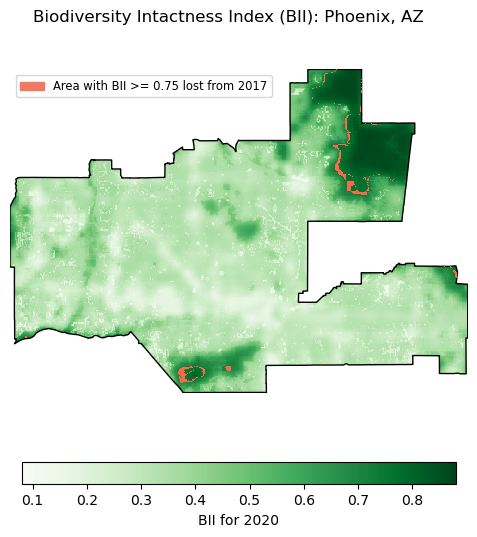

In [37]:
# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot 2020 BII
bii_2020_clip.plot(ax = ax,
                   cmap = "Greens",
                   add_colorbar = False)

# Save plot as object to be used for colorbar specification
bii = bii_2020_clip.plot(ax = ax,
                   cmap = "Greens",
                   add_colorbar = False)

# Plot the Phoenix polygon, coloring just the outline to create border
phoenix_sub.plot(edgecolor = "black",
                color = "none", 
                 ax =ax)

# Plot area lost mask
change_in_bii_mask.plot(
    ax=ax,
    cmap="Reds",
    add_colorbar=False)

# Add overall title, using combination of .suptitle and .title to control spacing
plt.suptitle('Biodiversity Intactness Index (BII): Phoenix, AZ')
plt.title(" ")

## Legends
# Add colorbar, making it smaller and horizontal
fig.colorbar(bii, orientation = "horizontal", label = "BII for 2020", shrink = 0.7)

# Manually set a legend for the area lost mask, matching plotted color and adding label
red_patch = mpatches.Patch(color= '#ed7a61', label='Area with BII >= 0.75 lost from 2017')
plt.legend(handles=[red_patch], loc = "upper left", fontsize = "small")

# Turn of axes as they don't give us any beneficial information
ax.axis('off')

plt.show()

## Results

By comparing our first plot of the Phoenix subdivision in context (with the streetmap basemap details) to the BII data, it becomes clear that the highest BII occurs in the parks and preserves that exist in the northeast and south of Phoenix. 

The orange on our final plot, which corresponds to area lost, appears mostly surrounding that area. From this, we can hypothesize that losses to biodiversity could be a result of urbanization enroaching/having an effect on formerly preserved land. This is also confirmed by our previous findings, where we saw that the percentage of land that had a BII of at least 0.75 decreased from 4.18% in 2017 to 3.81% in 2020.